In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn')
rng = np.random.default_rng(1234) # our random number generator from seed

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

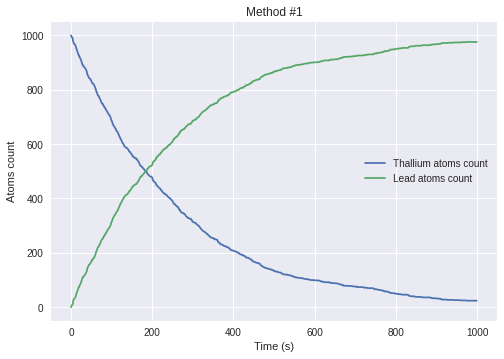

In [18]:
tau = 3.052*60 # half life in seconds

# Number 1
n_steps = 1000
steps = np.arange(n_steps)
tl = np.empty_like(steps)
pb = np.empty_like(steps)
p_t = 1-2**(-steps/tau)
tl[0] = 1000
pb[0] = 0
z = rng.uniform(size=tl[0])
mask = np.ones(1000,dtype=bool) # mask: true if not decayed


for step in steps[1:]:
    n_decayed=np.count_nonzero(z[mask]<=p_t[step]) # count the atoms that did decay
    mask=z>=p_t[step]
    tl[step] = tl[step-1] - n_decayed
    pb[step] = pb[step-1] + n_decayed


fig,ax = plt.subplots(1,1)
ax.set_title('Method #1')
ax.plot(steps,tl,label='Thallium atoms count')
ax.plot(steps,pb,label='Lead atoms count')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Atoms count')
ax.legend()
plt.show()


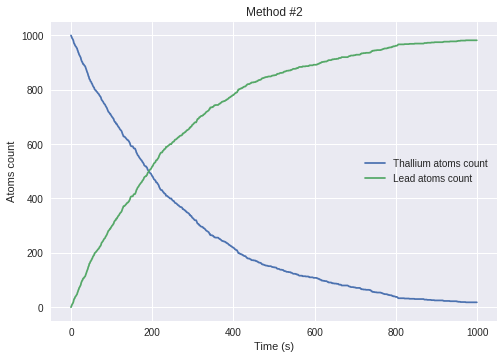

In [17]:
# NUMBER 2
z=rng.uniform(size=1000) # uniform number
times = -tau*np.log2(1-z) # inverse transform method
                          # these are the times at which each of the atoms will decay
decayed = np.empty_like(steps)
tl = np.empty_like(steps)
pb = np.empty_like(steps)

for step in steps:
    decayed[step]=np.count_nonzero(times<step)
    tl[step] = 1000-decayed[step]
    pb[step] = decayed[step]


fig,axs=plt.subplots(1,1)
axs.set_title('Method #2')
axs.plot(steps,tl,label='Thallium atoms count')
axs.plot(steps,pb,label='Lead atoms count')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Atoms count')
axs.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

Critical B: 2.9547e-15
Fraction of back-scattered atoms: 0.44%
Same fraction but computed by only checking the condition on the b parameter: 0.44%


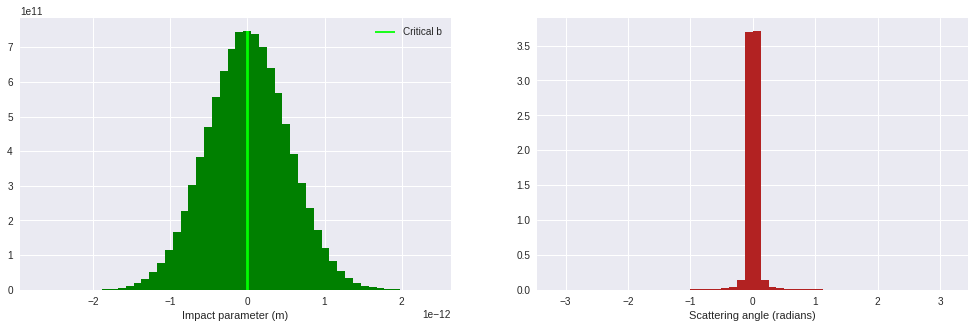

In [21]:
# what we need to do is to sample b values for 1 million alpha particles and count how many of them have theta>theta_crit(b)
# the impact parameter is only the radial component of the 2d gaussian and since it is symmetric to rotations it's again just a gaussian
# p(b) = C*e**(-b**2 / 2 sigma**2)

from scipy.constants import physical_constants
sigma = physical_constants['Bohr radius'][0] / 100
E=1.2337e-11 # JOULES
Z= 79
k = (Z * physical_constants['elementary charge'][0]**2)/(2*np.pi*physical_constants['vacuum electric permittivity'][0]*E)
def angle(b):
    return 2*np.arctan(k/b)

b_crit = k/(np.tan(np.pi/4)) # b critical: any impact parameter smaller than this will result in a back scattered particle
print("Critical B: {:.5}".format(b_crit))

# generate impact parameters
N = 1000000
b=rng.normal(0,sigma,N)
# get scattering angle
theta = angle(b)
n_backscattered=np.count_nonzero(abs(theta)>np.pi/2)
print("Fraction of back-scattered atoms: {:.2%}".format(n_backscattered/N))
print("Same fraction but computed by only checking the condition on the b parameter: {:.2%}".format((np.count_nonzero(np.abs(b)<b_crit))/N))


with plt.rc_context({'figure.figsize' : [17,5]}):
    fig,axs=plt.subplots(1,2)
    y,bins,patch=axs[0].hist(b,density=True,bins=50,color='g')
    axs[0].set_xlabel('Impact parameter (m)')
    axs[0].vlines([-b_crit,b_crit],0,y.max(),color='lime',label='Critical b')
    axs[1].hist(theta,density=True,bins=50,color='firebrick')
    axs[1].set_xlabel('Scattering angle (radians)')
    axs[0].legend()
    plt.show()


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

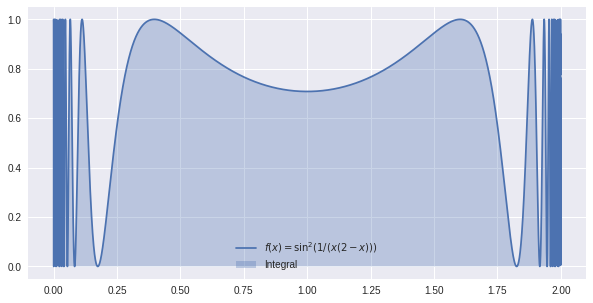

In [22]:
def func(x):
    return np.sin(1/(x*(2-x)))**2

with plt.rc_context({'figure.figsize' : [10,5]}):
    fig,ax = plt.subplots()
    x=np.linspace(0.0000001,2,10000,endpoint=False) # suppress divide by zero errors
    ax.plot(x,func(x),label='$f(x) =\sin^2{(1/(x(2-x)))}$')
    ax.fill_between(x,np.zeros_like(x),func(x),alpha=0.3,label='Integral')
    ax.legend()
    plt.show()

What's the error on the hit/miss MC integration method?
Assuming uniform and independently sampled $x_i,y_i$ within the intervals, respectively, $[0,l]$, $[0,h]$ where $lh=A$ are height and base of the area enclosing the integral, what this algorithm is doing is basically calculating the mean value of a function
$$g(x,y) = \begin{cases}
      1 & y<f(x) \\
      0        & otherwise
    \end{cases}
    $$

The error of I, given its estimation from the sampling, is then dependant on the sample variance, and scales with $\sqrt{N}$: 
$$
\sigma = V\frac{{\sigma_N}}{\sqrt{N}}
$$
Same as the mean value method which is simply reformulating the problem.

In [23]:
# mc integration
N = 1000
x = 2*rng.random(N)
y = rng.random(N)
count=np.count_nonzero(y<func(x)) # how many of the points landed below the graph?
A = 2
I = count*A/N
error = (2)*np.std([x,y])/np.sqrt(N)

print("Value of the integral via MC integration: ",I)
print("Estimated error: {:.2}".format(error))

Value of the integral via MC integration:  1.462
Estimated error: 0.033


In [24]:
# mean value integration

I = 2*np.mean(func(x))
error = (2)*np.std([x,y])/np.sqrt(N)

print("Value of the integral via MC integration (mean value): ",I)
print("Estimated error: {:.2}".format(error))

Value of the integral via MC integration (mean value):  1.4592525416122357
Estimated error: 0.033


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [25]:
def mc_volume_hypersphere(N,n):
    """
    Estimates the hypervolume of a hypersphere in n-dimensions using MC method with N samples.
    """
    V = 2**n
    x = 2*rng.random((n,N)) - 1 # sampling within the [-1,1] x n hypercube
    count=np.count_nonzero(np.linalg.norm(x,axis=0) < 1)
    I = count*V/N
    return I

from scipy.special import gamma

mc_res=[]
an_res=[]
N=1000000
for n in range(2,11):
    mc_res.append(mc_volume_hypersphere(N,n))
    an_res.append(np.pi**(n/2)/gamma(n/2 + 1))

results = pd.DataFrame({"MC" : mc_res, "Analytical" : an_res, "dimension" : [n for n in range(2,11)]})
results['error']=abs(results['Analytical']-results['MC'])/results['Analytical']
results.set_index('dimension')

,MC,Analytical,error
dimension,,,
2,3.141316,3.141593,0.000088
3,4.187184,4.188790,0.000383
4,4.937904,4.934802,0.000629
5,5.256000,5.263789,0.001480
6,5.188544,5.167713,0.004031
7,4.684416,4.724766,0.008540
8,4.017920,4.058712,0.010051
9,3.298816,3.298509,0.000093
10,2.514944,2.550164,0.013811


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

Integral value = 0.83905


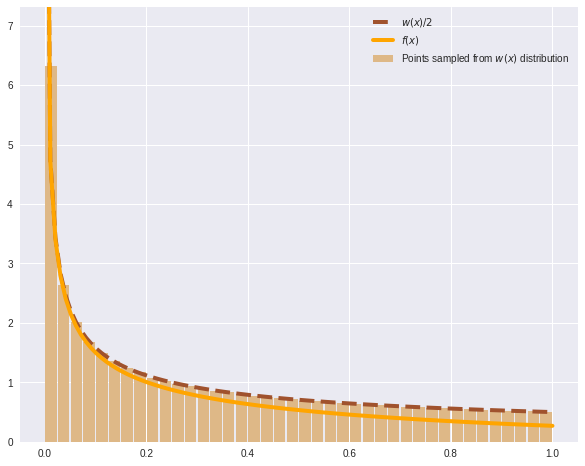

In [49]:
def w(x): return x**(-1/2)
def f(x): return (x**(-1/2))/(np.exp(x)+1)
def fw(x): return (np.exp(x)+1)**(-1) # lets use this to estimate the integral since it simplifies analytically the expression
# inverse transform method
def sample_w(shape):
    z=2*rng.random(size=shape) # multiply by two otherwise the uniform sampling from 0 to 1 transforms to a sampling of w(x) from 0 to 0.25
    return z**2 / 4

N = 1000000
x_s=sample_w(N)
I = 2./N * np.sum(fw(x_s)) # integral of w(x) from 0 to 1 is = 2

print("Integral value = {:.5}".format(I))


with plt.rc_context({'figure.figsize' : [10,8]}):
    fig,ax=plt.subplots()
    x=np.linspace(0.001,1,100) # 0.01 instead of 0 to suppress divide by zero warning
    ax.plot(x,w(x)/2,label='$w(x)/2$',linewidth=4,linestyle='--',color='sienna') # normalize w(x) as a pdf within [0,1] otherwise we can't see the overlap with the actual distribution
    hist,bins,patch=ax.hist(x_s,density=True,histtype='bar',bins=40,label='Points sampled from $w(x)$ distribution',color='burlywood',rwidth=0.9)
    ax.plot(x,f(x),label='$f(x)$',linewidth=4,color='orange')
    ax.set_ylim(0,hist.max()+1)
    ax.legend()
    plt.show()
